## CHEME 5660: Using Single Index Models and Boltzmann Weighted Data in Markowitz Portfolio Allocation

### Introduction
Fill me in.

### Example setup

In [1]:
import Pkg; Pkg.activate("."); Pkg.resolve(); Pkg.instantiate();

  Activating project at `~/Desktop/julia_work/CHEME-5660-Markets-Mayhem-Example-Notebooks/jupyter-notebooks/CHEME-5660-SIM-Boltzmann-Markowitz-notebook`
  No Changes to `~/Desktop/julia_work/CHEME-5660-Markets-Mayhem-Example-Notebooks/jupyter-notebooks/CHEME-5660-SIM-Boltzmann-Markowitz-notebook/Project.toml`
  No Changes to `~/Desktop/julia_work/CHEME-5660-Markets-Mayhem-Example-Notebooks/jupyter-notebooks/CHEME-5660-SIM-Boltzmann-Markowitz-notebook/Manifest.toml`


In [2]:
# load req packages -
using Convex
using SCS
using DataFrames
using Dates
using Colors
using Plots
using StatsPlots
using Statistics
using MathOptInterface
using FileIO
using JLD2
using PrettyTables
using Distributions
using LinearAlgebra

# setup paths -
const _ROOT = pwd();
const _PATH_TO_DATA = joinpath(_ROOT, "data");

In [3]:
include("Example-SIM-Boltzmann-Markowitz-CodeLib.jl");

In [4]:
# daily risk-free rate -
rÃÑ = 0.0403;
risk_free_daily = ((1+rÃÑ)^(1/365) - 1);

# how many days of historical data are we using?
mÃÇ = 596;
ŒªÃÇ = 0.001;

# 596

# step hist parameters -
number_of_bins = 80;

In [5]:
# load the JLD2 portfolio data file -
tmp = load(joinpath(_PATH_TO_DATA, "CHEME-5660-Portfolio-10-30-22.jld2"))["dd"];

In [6]:
# how many elements do we have in SPY?
spy_df_length = length(tmp["SPY"][!,:close]);

# go through each of the tickers and *remove* tickers that don't have the same length as SPY -
price_data_dictionary = Dict{String, DataFrame}();
for (ticker, test_df) ‚àà tmp
    
    # how long is test_df?
    test_df_length = length(test_df[!,:close])
    if (test_df_length == spy_df_length)
       price_data_dictionary[ticker] = test_df; 
    else
        println("Length violation: $(ticker) was removed; dim(SPY) = $(spy_df_length) days and dim($(ticker)) = $(test_df_length) days")
    end
end

# we have these ticker symbols in our data set -
ticker_symbol_array = sort(keys(price_data_dictionary) |> collect);

# How many tickers do we have?
N‚Çê = length(ticker_symbol_array);

Length violation: META was removed; dim(SPY) = 597 days and dim(META) = 247 days
Length violation: BIIB was removed; dim(SPY) = 597 days and dim(BIIB) = 596 days


In [7]:
# Compute (and visualize) same returns w and w/o weights -
ticker_to_explore = "MU"
(R, RÃÇ, W, Œº·µ¶, p·µ¶) = compute_excess_return(price_data_dictionary[ticker_to_explore]; m = mÃÇ, rf = risk_free_daily, Œª = ŒªÃÇ);

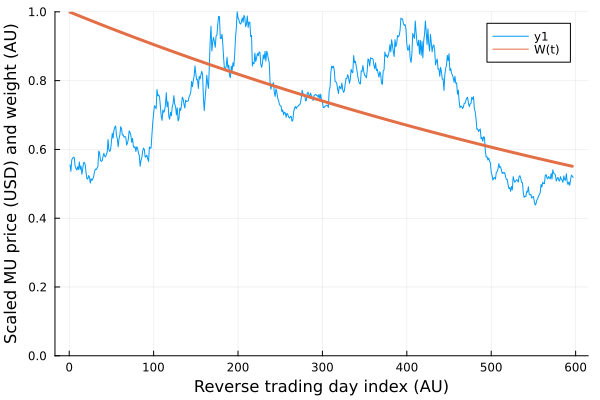

In [8]:
# grab data -
test_data = sort(price_data_dictionary[ticker_to_explore], [order(:timestamp, rev=true), :close]);

S‚Çí = maximum(test_data[!, :close])
S = test_data[!, :close]

plot(S./S‚Çí, ylim=(0.0,1.0))
plot!(W, lw=3, label="W(t)")

xlabel!("Reverse trading day index (AU)", fontsize=18)
ylabel!("Scaled $(ticker_to_explore) price (USD) and weight (AU)", fontsize=18)

In [9]:
println("mean R = $(mean(R)) and E(RÃÇ) = $(Œº·µ¶)")

mean R = 0.013403026122356096 and E(RÃÇ) = -0.014615907561514254


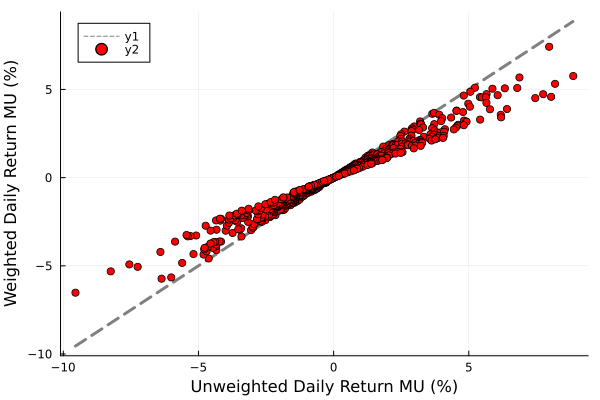

In [10]:
L = minimum(R);
U = maximum(R);

Z = range(L,stop=U,step=0.1) |> collect;
plot(Z,Z,lw=3, c=:gray, ls=:dash, legend=:topleft)
scatter!(R,RÃÇ, c=:red)
xlabel!("Unweighted Daily Return $(ticker_to_explore) (%)", fontsize=18)
ylabel!("Weighted Daily Return $(ticker_to_explore) (%)", fontsize=18)

### b) Estimate SIMs for each asset in our collection

#### Phase 1: Estimate $\left(\alpha_{i}, \beta_{i}\right)$ usind direct matrix inversion

In [11]:
# initialize -
sim_model_dictionary = Dict{String, SingleIndexModel}();

# compute the excess nreturn for SPY (which is in the data set)
(R‚Çò, RÃÇ‚Çò, W, Œº·µ¶, p·µ¶) = compute_excess_return(price_data_dictionary["SPY"]; 
    m = mÃÇ, rf = risk_free_daily, Œª = ŒªÃÇ);

# main loop -
for i ‚àà 1:N‚Çê
    
    # grab a ticker -
    asset_ticker = ticker_symbol_array[i];
    
    # compute the excess return for asset_ticker -
    (R·µ¢, RÃÇ·µ¢, W, Œº·µ¶, p·µ¶) = compute_excess_return(price_data_dictionary[asset_ticker]; 
        m = mÃÇ, rf = risk_free_daily, Œª = ŒªÃÇ);
    
    # formulate the Y and X arrays with the price data -
    max_length = length(RÃÇ·µ¢);
    Y = RÃÇ·µ¢;
    X = [ones(max_length) RÃÇ‚Çò];
    
    # compute Œ∏ -
    Œ∏ = inv(transpose(X)*X)*transpose(X)*Y
    
    # package -
    sim_model = SingleIndexModel();
    sim_model.Œ± = Œ∏[1];
    sim_model.Œ≤ = Œ∏[2];
    sim_model.r = risk_free_daily;
    sim_model_dictionary[asset_ticker] = sim_model;
end

#### Phase 2: Estimate the error models $\epsilon\left(t\right)$

In [12]:
# compute the error model -

# main loop -
for i ‚àà 1:N‚Çê
    
    # grab a ticker -
    asset_ticker = ticker_symbol_array[i];
    
    # grab the model -
    sim_model = sim_model_dictionary[asset_ticker];
    
    # compute the excess return for asset_ticker (data) -
    (R·µ¢, RÃÇ·µ¢, W, Œº·µ¶, p·µ¶) = compute_excess_return(price_data_dictionary[asset_ticker];  
        m = mÃÇ, rf = risk_free_daily, Œª = ŒªÃÇ);
        
    # compute the model excess return -
    Œ±·µ¢ = sim_model.Œ±
    Œ≤·µ¢ = sim_model.Œ≤
    R_prediction = Œ±·µ¢ .+ Œ≤·µ¢ .* RÃÇ‚Çò
    
    # compute the residual -
    Œî = RÃÇ·µ¢ .- R_prediction;
    
    # Esimate a distribution -
    d = fit_mle(Normal, Œî);
    
    # update the sim_model -
    sim_model.œµ = d;
end

##### Visualize SIM performance

In [13]:
# pick an asset -
asset_ticker = "AMD"
sim_model = sim_model_dictionary[asset_ticker];

# compute the excess return for asset_ticker (data) -
(R·µ¢, RÃÇ·µ¢, W, Œº·µ¶, p·µ¶) = compute_excess_return(price_data_dictionary[asset_ticker]; 
    rf = risk_free_daily, m = mÃÇ, Œª = ŒªÃÇ);

# evaluate the SIM (without noise) -
RÃÇ_model = evaluate_model(sim_model, sort(RÃÇ‚Çò));

# sample the SIM to get the uncertainty region -
RÃÇ_samples = sample_sim_model(sim_model, sort(RÃÇ‚Çò); ùí´ = 1000);

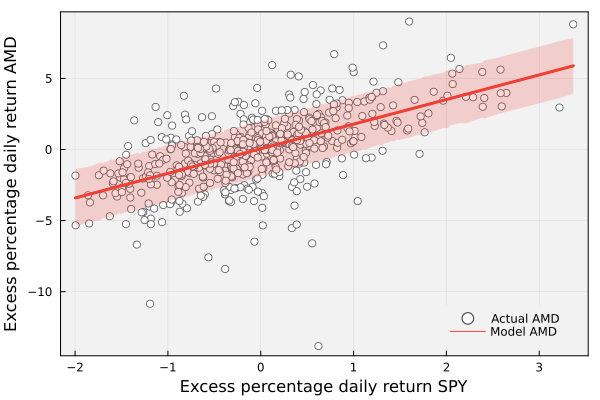

In [14]:
# data and expected value -
scatter(RÃÇ‚Çò, RÃÇ·µ¢, mc=colorant"#FFFFFF", msc=colorant"#55565A", label="Actual $(asset_ticker)", legend=:bottomright)

# uncertainty region -
L = RÃÇ_model .- std(RÃÇ_samples,dims=2)
U = RÃÇ_model .+ std(RÃÇ_samples,dims=2)

plot!(sort(RÃÇ‚Çò), RÃÇ_model, fillrange=U, fillalpha = 0.2, lw=2, label="", c=colorant"#EF4035")
plot!(sort(RÃÇ‚Çò), RÃÇ_model, fillrange=L, fillalpha = 0.2, lw=2, label="", c=colorant"#EF4035")

plot!(sort(RÃÇ‚Çò), RÃÇ_model, lw=3, c=colorant"#EF4035", bg=colorant"#F2F2F2", 
    background_color_outside="white", framestyle = :box, fg_legend = :transparent, label="Model $(asset_ticker)")


# labels -
xlabel!("Excess percentage daily return SPY",fontsize=18)
ylabel!("Excess percentage daily return $(asset_ticker)",fontsize=18)

# uncomment me to save figure to disk -
#filename = "Fig-SIM-$(asset_ticker)-m-200-11-3-2022.pdf";
#savefig(joinpath(_PATH_TO_FIGS, filename));

### c) Markowitz Allocation using Single Index Models of Risk and Return

In [15]:
# compute the Œº_vector -
Œº_vector = Œº(sim_model_dictionary, RÃÇ‚Çò, ticker_symbol_array);

In [16]:
# compute Œ£ -
Œ£_array = Œ£(sim_model_dictionary, RÃÇ‚Çò, ticker_symbol_array);

In [17]:
# define the returns that we are going to simulate -
target_return_array = 100 .*range(0.0, step=0.0001, stop = 0.003) |> collect # percentage
L = length(target_return_array);

In [18]:
# Initialize MinVar array
# row: return
# col 1 -> risk
# col 2 -> return
# col 3 ... N -> allocation
MinVarArray = Array{Float64,2}(undef,L, (N‚Çê + 2));

# main loop: pick a return, run the calculation. If solver converged, store results
for i = 1:L

    tr = target_return_array[i]
    (status_flag, œâ, opt_val, ret_val) = compute_minvar_portfolio_allocation(Œº_vector, Œ£_array, tr; w_lower = 0.0);

    if (status_flag == MathOptInterface.OPTIMAL)
        
        MinVarArray[i,1] = opt_val;
        MinVarArray[i,2] = ret_val;
        
        # capture the allocation
        for a ‚àà 1:N‚Çê
            MinVarArray[i,2+a] = œâ[a]
        end
    end
end

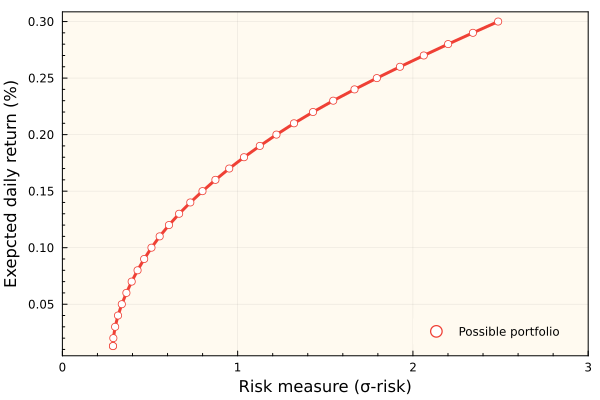

In [19]:
# pull out the risk and rerturn -
risk_array = sqrt.(MinVarArray[:,1])
return_array = MinVarArray[:,2];

# plot -
plot(risk_array, return_array, label="", c=colorant"#EF4035", legend=:bottomright, bg="floralwhite", 
background_color_outside="white", framestyle = :box, fg_legend = :transparent, lw=3, xlim=(0.0,3.0),minorticks=0.1)
scatter!(risk_array, return_array, label="Possible portfolio", mc=:white, msc=colorant"#EF4035")
xlabel!("Risk measure (œÉ-risk)", fontsize=18)
ylabel!("Exepcted daily return (%)", fontsize=18)

### d) Markowitz Allocation using Single Index Models of Risk and Return (risky+risk-free)

In [20]:
# Initialize MinVarRiskFree array
# row: return
# col 1 -> risk
# col 2 -> return
# col 3 ... N -> allocation
MinVarRiskFreeArray = Array{Float64,2}(undef, L, (N‚Çê + 2));

# main loop: pick a return, run the calculation. If solver converged, store results
for i = 1:L

    tr = target_return_array[i]
    (status_flag, œâ, opt_val, ret_val) = compute_minvar_portfolio_allocation_risk_free(Œº_vector, Œ£_array, tr;
        risk_free_return = risk_free_daily, w_lower =  0.0);

    if (status_flag == MathOptInterface.OPTIMAL)
        
        # capture the risk and reward values -
        MinVarRiskFreeArray[i,1] = opt_val;
        MinVarRiskFreeArray[i,2] = ret_val;
        
        # capture the allocation
        for a ‚àà 1:N‚Çê
            MinVarRiskFreeArray[i,2+a] = œâ[a]
        end
    end
end

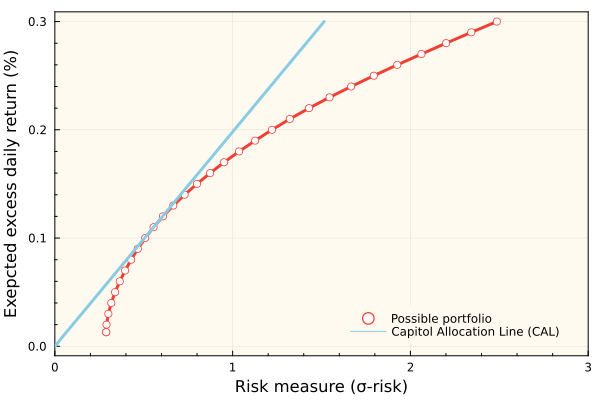

In [24]:
# pull out the risk and rerturn for the risk-free case -
risk_array_rf = sqrt.(MinVarRiskFreeArray[:,1])
return_array_rf = MinVarRiskFreeArray[:,2];

# plot the risk-only portfolio -
plot(risk_array, return_array, label="", c=colorant"#EF4035", legend=:bottomright, bg="floralwhite", 
background_color_outside="white", framestyle = :box, fg_legend = :transparent, lw=3, minorticks=0.05, xlim=(0.0,3.0))
scatter!(risk_array, return_array, label="Possible portfolio", mc=:white, msc=colorant"#EF4035")

# plot the CAL -

plot!(risk_array_rf,  return_array_rf, lw=3, c=colorant"#89CCE2", label="Capitol Allocation Line (CAL)")

# axis labels -
xlabel!("Risk measure (œÉ-risk)", fontsize=18)
ylabel!("Exepcted excess daily return (%)", fontsize=18)

In [27]:
# make a allocation table for risky+risk free asset case -

# what portfolio index do we need?
portfolio_index_rf = findall(x->x<=0.52, risk_array_rf)[end]
Œ¥ = 0.005; # what is my cutoff?

# find the indexes of the assets that are "not small" -
idx_not_small_rf = findall(x-> abs(x) >= Œ¥, MinVarRiskFreeArray[portfolio_index_rf,3:end])
A = length(idx_not_small_rf);

# setup table -
allocation_table_data_rf = Array{Any,2}(undef, A+1, 4);
for a ‚àà 1:A
    
    # grab the data -
    idx = idx_not_small_rf[a];
    ticker = ticker_symbol_array[idx]
    œâ‚Çê = MinVarRiskFreeArray[portfolio_index_rf,(idx .+ 2)];

    # package -
    allocation_table_data_rf[a,1] = ticker;
    allocation_table_data_rf[a,2] = œâ‚Çê
    allocation_table_data_rf[a,3] = Œº_vector[idx];
    allocation_table_data_rf[a,4] = Œ£_array[idx,idx];
end

# add a total row -
allocation_table_data_rf[end,1] = "Total"
allocation_table_data_rf[end,2] = sum(MinVarRiskFreeArray[portfolio_index_rf, (idx_not_small_rf .+ 2)])
allocation_table_data_rf[end,3] = MinVarRiskFreeArray[portfolio_index_rf,2];
allocation_table_data_rf[end,4] = sqrt.(MinVarRiskFreeArray[portfolio_index_rf,1])

# header -
allocation_table_header_rf = (["Ticker", "weight", "E(r)", "œÉ"])

# show the table -
pretty_table(allocation_table_data_rf; header = allocation_table_header_rf)

‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ Ticker ‚îÇ     weight ‚îÇ      E(r) ‚îÇ        œÉ ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ     BA ‚îÇ  0.0322438 ‚îÇ 0.0484539 ‚îÇ  4.63949 ‚îÇ
‚îÇ    BIO ‚îÇ 0.00942986 ‚îÇ 0.0129218 ‚îÇ  2.58175 ‚îÇ
‚îÇ      C ‚îÇ  0.0102142 ‚îÇ 0.0130942 ‚îÇ  2.46994 ‚îÇ
‚îÇ    CLX ‚îÇ   0.071793 ‚îÇ 0.0522179 ‚îÇ  1.83546 ‚îÇ
‚îÇ    CRM ‚îÇ 0.00919789 ‚îÇ 0.0164664 ‚îÇ   3.6053 ‚îÇ
‚îÇ   INTC ‚îÇ   0.097475 ‚îÇ  0.092838 ‚îÇ  3.15581 ‚îÇ
‚îÇ    KMB ‚îÇ  0.0372646 ‚îÇ 0.0137982 ‚îÇ  0.87797 ‚îÇ
‚îÇ    MMM ‚îÇ  0.0372844 ‚îÇ  0.017444 ‚îÇ   1.2046 ‚îÇ
‚îÇ   NFLX ‚îÇ  0.0317416 ‚îÇ 0.0759933 ‚îÇ  6.74323 ‚îÇ
‚îÇ    SWK ‚îÇ  0.0706591 ‚îÇ 0.0457692 ‚îÇ  2.14582 ‚îÇ
‚îÇ      T ‚îÇ   0.112911 ‚îÇ 0.0594125 ‚îÇ  1.44536 ‚îÇ
‚îÇ    VXX ‚îÇ   0.182947 ‚îÇ  0.3465